# Advanced Regression Technique

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

## Import Dataset

In [90]:
# Import Dataset
test = pd.read_csv('/Users/wasin/Desktop/DA_Project/house-prices-advanced-regression-techniques/test.csv',index_col='Id')
train = pd.read_csv('/Users/wasin/Desktop/DA_Project/house-prices-advanced-regression-techniques/train.csv',index_col='Id')

In [91]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Divide numerical and categorical columns

In [92]:
# Divide numerical and categorical columns to analyse them seperately.

# numerical
num_cols = train.select_dtypes(include=['int','float64']).columns
# categorical
cat_cols = train.select_dtypes(include=['object']).columns
# Index to list
num_cols = num_cols.tolist()
cat_cols = cat_cols.tolist()
# Seperate num_cols and cat_cols dataframe
num_cols = train.loc[:, num_cols]
cat_cols = train.loc[:, cat_cols]

## Analyze num_cols

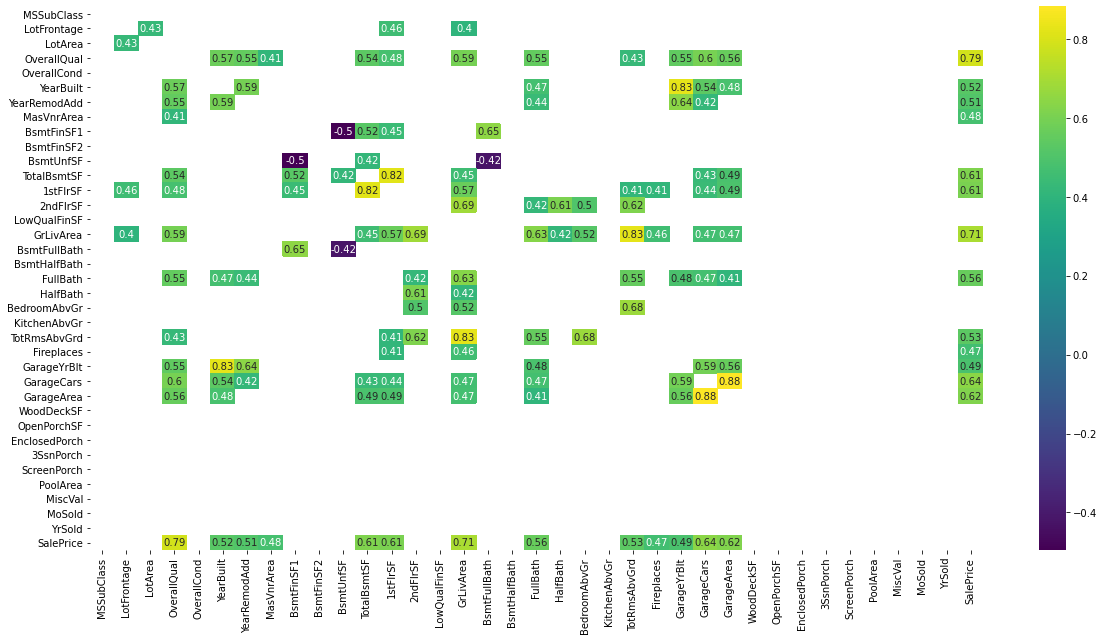

In [93]:
# Analyse numerical columns to identify the most relevent columns for the model.

# Plot heatmap to visualize correlation for num_cols
dfCorr = num_cols.corr()
filteredDf = dfCorr[((dfCorr >= .4) | (dfCorr <= -.4)) & (dfCorr !=1.000)]
plt.figure(figsize=(20,10))
sns.heatmap(filteredDf, annot=True, cmap="viridis",)
plt.show()

In [94]:
 # Creating a function to filter  and flattend correlation dataframe
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# Set the correlation level at minimum of absolute 0.45
most_corr = corrFilter(num_cols, .4)

most_corr = most_corr.reset_index().rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'Correlation'})
most_corr = most_corr.loc[ (most_corr['var1'] == 'SalePrice') | (most_corr['var2'] == 'SalePrice')].sort_values('Correlation',ascending=False)
most_corr

,var1,var2,Correlation
65,OverallQual,SalePrice,0.790982
64,GrLivArea,SalePrice,0.708624
59,GarageCars,SalePrice,0.640409
57,GarageArea,SalePrice,0.623431
55,TotalBsmtSF,SalePrice,0.613581
53,1stFlrSF,SalePrice,0.605852
44,SalePrice,FullBath,0.560664
37,SalePrice,TotRmsAbvGrd,0.533723
36,YearBuilt,SalePrice,0.522897
33,YearRemodAdd,SalePrice,0.507101


In [105]:
# Display a list of candidate  columns
candidates_num_cols = most_corr['var1'].astype(str).values.tolist() + most_corr['var2'].astype(str).values.tolist() 
candidates_num_cols_train = list(dict.fromkeys(candidates_num_cols)) 
candidates_num_cols_test  = list(dict.fromkeys(candidates_num_cols)) 
# Drop 'GarageCars' since similar to 'GarageArea'
candidates_num_cols_train.remove("GarageArea")
candidates_num_cols_test.remove("GarageArea")
candidates_num_cols_train.remove("SalePrice")
candidates_num_cols_test.remove("SalePrice")

In [143]:
X = train.loc[:, candidates_num_cols_train]
y = train.loc[:, 'SalePrice' ]

In [148]:
X_columns = X.columns
X

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageYrBlt,Fireplaces,FullBath,TotRmsAbvGrd,MasVnrArea
Id,,,,,,,,,,,,
1,7,1710,2,856,856,2003,2003,2003.0,0,2,8,196.0
2,6,1262,2,1262,1262,1976,1976,1976.0,1,2,6,0.0
3,7,1786,2,920,920,2001,2002,2001.0,1,2,6,162.0
4,7,1717,3,756,961,1915,1970,1998.0,1,1,7,0.0
5,8,2198,3,1145,1145,2000,2000,2000.0,1,2,9,350.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,6,1647,2,953,953,1999,2000,1999.0,1,2,7,0.0
1457,6,2073,2,1542,2073,1978,1988,1978.0,2,2,7,119.0
1458,7,2340,1,1152,1188,1941,2006,1941.0,2,2,9,0.0


In [149]:
y

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1460, dtype: int64

In [150]:
# Fill missing values
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
X = np.array(imputer.fit_transform(X))

## Splitting Data

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Training the Multiple Linear Regression model on the Training set

In [157]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train) 

LinearRegression()

## Predicting Test Data

In [160]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)

Text(0, 0.5, 'Predicted Y')

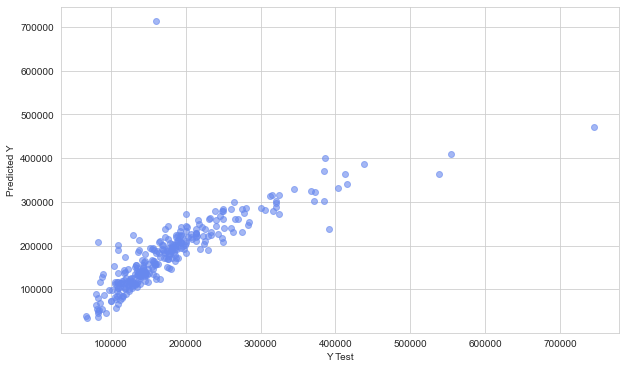

In [172]:
#Predicted vs True
sns.set_palette("coolwarm")
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred,alpha=0.6)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [179]:
# The coefficients
coeffecients = pd.DataFrame(regressor.coef_, X_columns)
coeffecients.columns = ['Coeffecient']
coeffecients.sort_values('Coeffecient', ascending=False)

,Coeffecient
OverallQual,15958.776315
GarageCars,10732.333340
Fireplaces,9254.964402
YearRemodAdd,381.212803
YearBuilt,218.812697
GrLivArea,51.028397
GarageYrBlt,39.415638
MasVnrArea,35.935222
TotalBsmtSF,31.459522
1stFlrSF,10.213032


 ##  Model Evaluation

In [186]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 25659.147774159715
MSE: 2359035316.3993955
RMSE: 48569.901342286


/Users/wasin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


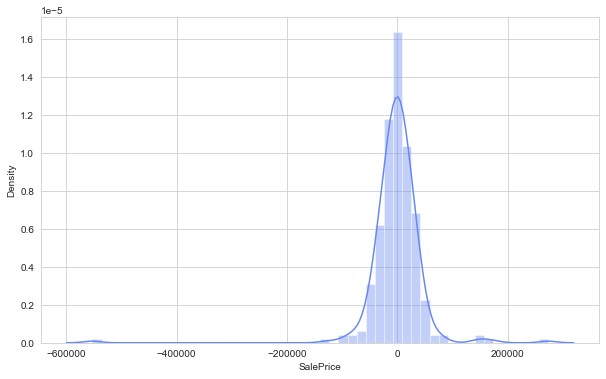

In [188]:
 # Residual
plt.figure(figsize=(10,6))
sns.distplot((y_test-y_pred),bins=50);
# Uniformly distributed